<a href="https://colab.research.google.com/github/murillofnc22/labs-bairesdev-ml-training/blob/main/SistemaRecomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# Instalação de dependências
!pip install -q tensorflow tensorflow_hub annoy pandas tqdm

In [56]:
# Importações necessárias
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os
from pathlib import Path
from tqdm import tqdm
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shutil import move
import random

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# Configurações
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
N_FEATURES = 1280  # MobileNetV2 tem 1280 features

TF version: 2.19.0
Hub version: 0.16.1
GPU is available


In [57]:

# 1. Aquisição e preparação dos dados
def prepare_fashion_dataset():
    """Prepara o dataset de moda"""
    !unzip -q /content/fashion-product-images-small.zip

    # Criar estrutura de diretórios
    os.makedirs('/content/Fashion_data/categories', exist_ok=True)

    # Ler metadados
    df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
    df['id'] = df['id'].astype('str')

    # Mover imagens para categorias
    all_images = os.listdir('/content/images/')
    for image in tqdm(all_images):
        try:
            category = df[df['id'] == image.split('.')[0]]['masterCategory'].values[0]
            category_dir = os.path.join('/content/Fashion_data/categories', category)
            os.makedirs(category_dir, exist_ok=True)

            path_from = os.path.join('/content/images', image)
            path_to = os.path.join(category_dir, image)
            move(path_from, path_to)
        except:
            continue

    print('Preparação do dataset concluída!')

# 2. CORREÇÃO: Carregar/criar extrator de características
def create_feature_extractor():
    """Cria o extrator de características usando MobileNet"""
    # Método alternativo que funciona com versões recentes do TF
    try:
        # Tentativa 1: Usar a abordagem funcional
        model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

        # Criar modelo usando a API funcional
        input_layer = tf.keras.layers.Input(shape=IMAGE_SIZE + (3,))
        hub_layer = hub.KerasLayer(model_url, input_shape=IMAGE_SIZE + (3,), trainable=False)
        x = hub_layer(input_layer)
        x = tf.keras.layers.Dropout(rate=0.2)(x)

        model = tf.keras.Model(inputs=input_layer, outputs=x)
        return model

    except Exception as e:
        print(f"Erro com abordagem funcional: {e}")

        # Tentativa 2: Usar modelo pré-carregado
        try:
            print("Tentando abordagem alternativa...")
            model = tf.keras.Sequential([
                tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
                tf.keras.layers.Lambda(lambda x: x / 255.0),  # Normalização
                tf.keras.applications.MobileNetV2(
                    input_shape=IMAGE_SIZE + (3,),
                    include_top=False,
                    weights='imagenet',
                    pooling='avg'  # Global average pooling
                )
            ])
            return model

        except Exception as e2:
            print(f"Erro com MobileNetV2 nativo: {e2}")

            # Tentativa 3: Modelo mais simples
            print("Usando modelo simplificado...")
            model = tf.keras.Sequential([
                tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
                tf.keras.layers.Lambda(lambda x: x / 255.0),
                tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
                tf.keras.layers.MaxPooling2D((2, 2)),
                tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                tf.keras.layers.MaxPooling2D((2, 2)),
                tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(512, activation='relu')
            ])
            return model

# 3. Processar imagens e gerar embeddings
def process_images_and_generate_embeddings(feature_extractor, image_dir):
    """Processa imagens e gera embeddings"""
    image_paths = []
    embeddings = []

    # Coletar paths das imagens
    for path in Path(image_dir).rglob('*.jpg'):
        image_paths.append(str(path))

    # Limitar número de imagens para teste
    image_paths = image_paths[:300]  # Processar apenas 300 imagens para teste

    # Processar em lotes para economizar memória
    for i in tqdm(range(0, len(image_paths), BATCH_SIZE)):
        batch_paths = image_paths[i:i+BATCH_SIZE]
        batch_images = []
        valid_paths = []

        # Carregar e pré-processar imagens
        for img_path in batch_paths:
            try:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                batch_images.append(img_array)
                valid_paths.append(img_path)
            except Exception as e:
                print(f"Erro ao processar {img_path}: {e}")
                continue

        if batch_images:
            try:
                # Converter para tensor e normalizar
                batch_arrays = tf.convert_to_tensor(batch_images, dtype=tf.float32) / 255.0

                # Gerar embeddings em lote
                batch_embeddings = feature_extractor(batch_arrays)
                embeddings.extend(batch_embeddings.numpy())
                image_paths.extend(valid_paths)
            except Exception as e:
                print(f"Erro ao gerar embeddings: {e}")
                continue

    return image_paths[:len(embeddings)], np.array(embeddings)

# 4. Construir índice de similaridade
def build_similarity_index(embeddings, metric='angular'):
    """Constrói o índice Annoy para busca por similaridade"""
    if len(embeddings) == 0:
        raise ValueError("Nenhum embedding foi gerado")

    index = AnnoyIndex(embeddings.shape[1], metric)

    for i, embedding in enumerate(embeddings):
        index.add_item(i, embedding)

    index.build(10)  # 10 árvores
    return index

# 5. Sistema de recomendação
class ImageRecommender:
    def __init__(self, image_paths, embeddings):
        self.image_paths = image_paths
        self.embeddings = embeddings
        if embeddings is not None and len(embeddings) > 0:
            self.index = build_similarity_index(embeddings)
        else:
            self.index = None
            print("Aviso: Nenhum embedding disponível")

    def get_similar_images(self, query_image_path, feature_extractor, num_results=5):
        """Encontra imagens similares"""
        try:
            # Processar imagem de consulta
            query_img = tf.keras.preprocessing.image.load_img(query_image_path, target_size=IMAGE_SIZE)
            query_array = tf.keras.preprocessing.image.img_to_array(query_img)
            query_array = tf.expand_dims(query_array, 0) / 255.0

            # Gerar embedding da consulta
            query_embedding = feature_extractor(query_array).numpy()[0]

            # Buscar similares
            similar_indices = self.index.get_nns_by_vector(query_embedding, num_results + 1)[1:]
            similar_paths = [self.image_paths[i] for i in similar_indices if i < len(self.image_paths)]

            return similar_paths
        except Exception as e:
            print(f"Erro ao buscar imagens similares: {e}")
            return []

    def display_similar_images(self, query_path, similar_paths):
        """Exibe a imagem de consulta e as similares"""
        if not similar_paths:
            print("Nenhuma imagem similar encontrada")
            return

        plt.figure(figsize=(15, 5))

        # Imagem de consulta
        plt.subplot(1, len(similar_paths) + 1, 1)
        try:
            plt.imshow(mpimg.imread(query_path))
            plt.title('Consulta')
            plt.axis('off')
        except:
            plt.title('Erro ao carregar consulta')
            plt.axis('off')

        # Imagens similares
        for i, path in enumerate(similar_paths):
            plt.subplot(1, len(similar_paths) + 1, i + 2)
            try:
                plt.imshow(mpimg.imread(path))
                plt.title(f'Similar {i+1}')
                plt.axis('off')
            except:
                plt.title(f'Erro ao carregar {i+1}')
                plt.axis('off')

        plt.tight_layout()
        plt.show()

In [58]:
# 1. Preparar dataset
print("Preparando dataset...")
prepare_fashion_dataset()

Preparando dataset...
replace images/22885.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


100%|██████████| 44441/44441 [03:20<00:00, 221.78it/s]

Preparação do dataset concluída!


In [59]:
# 2. Criar extrator de características
print("Criando extrator de características...")
feature_extractor = create_feature_extractor()

print("Feature extractor criado com sucesso!")
print("Resumo do modelo:")
feature_extractor.summary()

Criando extrator de características...
Erro com abordagem funcional: Exception encountered when calling layer 'keras_layer_13' (type KerasLayer).

A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

Call arguments received by layer 'keras_layer_13' (type KerasLayer):
  • inputs=<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_650>
  • training=None
Tentando abordagem alternativa...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Feature extractor criado com sucesso!
Resumo do modelo:


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_4 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [60]:
# 3. Processar imagens
print("Processando imagens e gerando embeddings...")
image_dir = '/content/Fashion_data/categories'
image_paths, embeddings = process_images_and_generate_embeddings(feature_extractor, image_dir)

print(f"Processadas {len(image_paths)} imagens")
print(f"Embeddings shape: {embeddings.shape}")

Processando imagens e gerando embeddings...


100%|██████████| 10/10 [00:31<00:00,  3.15s/it]

Processadas 320 imagens
Embeddings shape: (320, 1280)


In [61]:
# 4. Criar sistema de recomendação
print("Construindo sistema de recomendação...")
recommender = ImageRecommender(image_paths, embeddings)

Construindo sistema de recomendação...


Testando o sistema...
Imagem de teste: /content/Fashion_data/categories/Footwear/49460.jpg


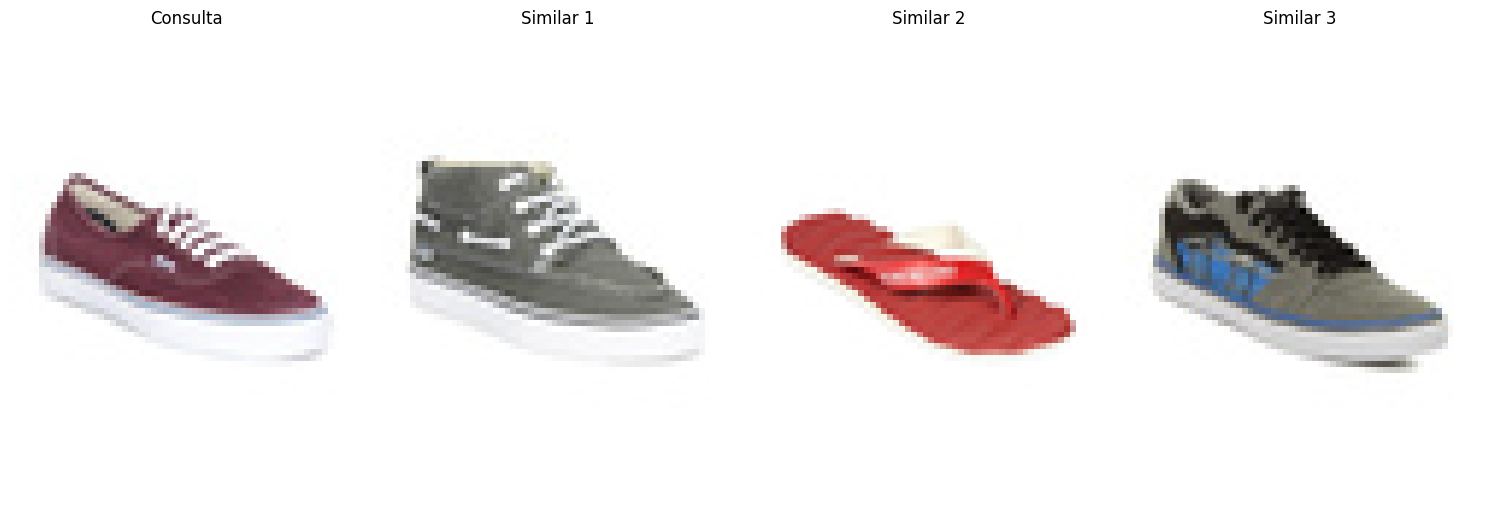

In [62]:
# 5. Testar com uma imagem aleatória
print("Testando o sistema...")
if image_paths:
  random_image = random.choice(image_paths)
  print(f"Imagem de teste: {random_image}")

  similar_images = recommender.get_similar_images(random_image, feature_extractor, 3)

  if similar_images:
    # 6. Mostrar resultados
    recommender.display_similar_images(random_image, similar_images)
  else:
    print("Nenhuma imagem similar encontrada.")
else:
  print("Nenhuma imagem foi processada.")